In [1]:
from pynq import Overlay, allocate
import numpy as np
from PIL import Image

In [2]:
overlay = Overlay('/home/xilinx/pynq/overlays/grayscale/grayscale.bit')

In [3]:
grayscale = overlay.grayscale_kernel_0
dma = overlay.axi_dma_0

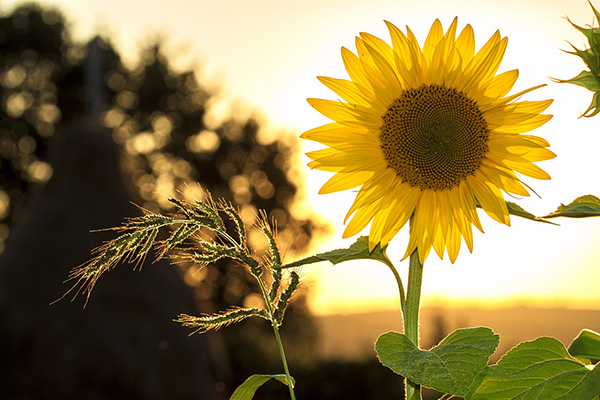

In [4]:
img = Image.open('/home/xilinx/jupyter_notebooks/1.jpg')
img

In [5]:
img_array = np.array(img)

# Combine the three channels into one 32-bit integer per pixel:
# For each pixel: (R << 16) | (G << 8) | B
combined_array = ((img_array[:,:,0].astype(np.uint32) << 16) |
                  (img_array[:,:,1].astype(np.uint32) << 8)  |
                  img_array[:,:,2].astype(np.uint32))

In [6]:
in_buffer = allocate(combined_array.shape, dtype=np.uint32)
in_buffer[:] = combined_array  # Copy the combined values into the buffer

print("in_buffer shape:", in_buffer.shape)
print("First pixel in in_buffer (in hex):", hex(in_buffer[0, 0]))

out_buffer = allocate(combined_array.shape, dtype=np.uint32)

in_buffer shape: (400, 600)
First pixel in in_buffer (in hex): 0xf0e2b1


In [7]:
in_buffer

PynqBuffer([[15786673, 16313532, 16773830, ..., 16772304, 16772813,
             16052937],
            [15918259, 16379325, 16708037, ..., 16773066, 16773322,
             16381134],
            [15918513, 16313017, 16576450, ..., 16641731, 16773833,
             16708047],
            ...,
            [  525568,   525568,   525568, ...,  6252288,  6445827,
              4465928],
            [  591361,   591361,   591361, ...,  5527808,  7235853,
              5652235],
            [  657154,   591361,   657154, ...,  5988615,  6908167,
              6115086]], dtype=uint32)

In [8]:
width = combined_array.shape[1]
height = combined_array.shape[0]

grayscale.write(0x10, width) 
grayscale.write(0x18, height)

In [9]:
grayscale.write(0x00, 1) 
dma.sendchannel.transfer(in_buffer)
dma.recvchannel.transfer(out_buffer)

In [10]:
dma.sendchannel.wait()
dma.recvchannel.wait()

In [11]:
while grayscale.read(0x00) & 0x4 == 0:
        pass

In [12]:
out_buffer

PynqBuffer([[14211288, 14869218, 15329769, ..., 15198183, 15263976,
             15329769],
            [14342874, 14935011, 15263976, ..., 15263976, 15329769,
             15527148],
            [14342874, 14737632, 15132390, ..., 15066597, 15395562,
             15395562],
            ...,
            [  263172,   263172,   263172, ...,  5263440,  4737096,
              2171169],
            [  328965,   328965,   328965, ...,  4539717,  5592405,
              3487029],
            [  394758,   328965,   394758, ...,  5066061,  5526612,
              4342338]], dtype=uint32)

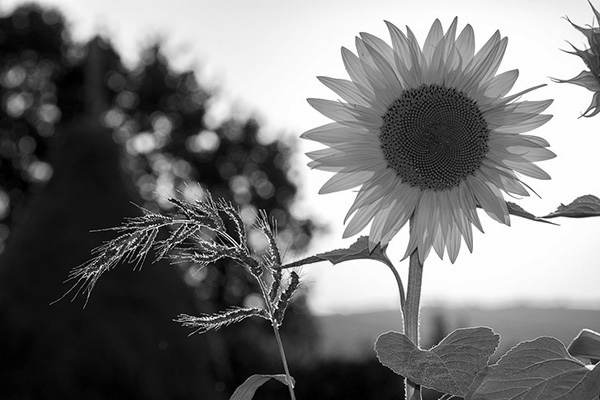

In [13]:
# Extract the individual R, G, B channels using vectorized operations:
r_channel = (out_buffer >> 16) & 0xFF
g_channel = (out_buffer >> 8) & 0xFF
b_channel = out_buffer & 0xFF

# Stack the channels along the last axis to form a 3D array with shape (height, width, 3)
img_array = np.stack((r_channel, g_channel, b_channel), axis=-1).astype(np.uint8)

# Convert the NumPy array back to a PIL Image in RGB mode
img_out = Image.fromarray(img_array, mode='RGB')

img_out